# Applying NMF to White-Light Calibration Scans

The mask slide mechanism in OSIRIS loses steps as it is scanning across the lenslet array during the white-light scan process.  As a result, it is likely that the mask is not perfectly aligned with the lenslets.  Individual exposures may partially illuminate 2 columns.

Tutorial data was taken using the Kn3 filter. More information about OSIRIS filters, scales, and fields of view can be found at: https://www2.keck.hawaii.edu/inst/osiris/scale_filter.html

Tutorial data can be found at: https://drive.google.com/drive/folders/1WKsadf16FzLTS6vSM_3Pk-qFmk1FtZXb?usp=sharing. Please request access to view the data on the google drive. 

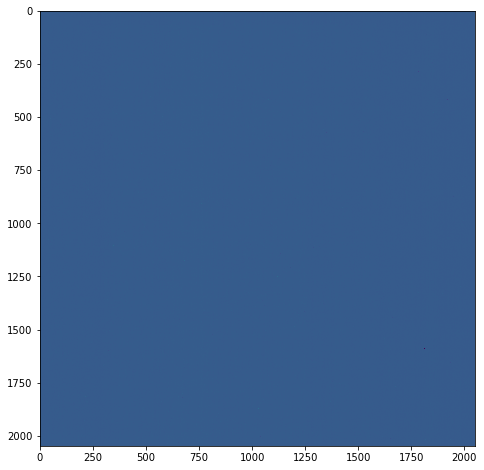

In [4]:
import os
import numpy as n
import matplotlib as mpl
import pylab
from astropy.io import fits

#directory where the raw images live 
#raw_dir = os.path.expanduser('~/YOUR_PATH/NMF_tutorial_files/')
raw_dir = os.path.expanduser('NMF_tutorial_files/')

# process darks
# darks are the first 5 images in this folder 
raw_dark_fns = [raw_dir+'s200904_a0030{:02d}.fits'.format(i) for i in range(1,6)]
raw_darks = n.array([fits.getdata(fn) for fn in raw_dark_fns])
dark = n.median(raw_darks, axis=0)

# process scans and subtract darks 
raw_scan_fns = [raw_dir+'s200904_a003{:03d}.fits'.format(i) for i in range(6,57)]
scans = n.array([fits.getdata(fn)-dark for fn in raw_scan_fns])
n_scan = len(scans)
root = 'Kn3'

# reformat scan array
n_im, ny, nx = scans.shape
npix = ny*nx
scans.shape = n_im, npix

#compute median
mscan = n.median(scans, axis=0)
fig = pylab.figure(figsize=(8,8))
fig.clear()
ax = fig.add_subplot(111)
ax.imshow(n.reshape(mscan, (ny,nx)),
         interpolation='nearest',
         )
pylab.draw()
pylab.show()

In [6]:
#remove median
scans -= mscan[n.newaxis,:]

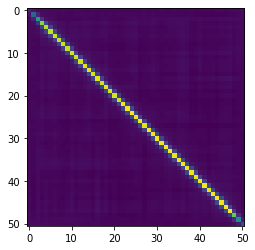

In [44]:
#compute covariance array
cov = n.dot(scans, scans.T)

# show the array
fig = pylab.figure()
fig.clear()
ax = fig.add_subplot(111)
ax.imshow(cov,
          interpolation='nearest',
          #cmap=mpl.cm.RdBu,
         )
pylab.draw()
pylab.show()

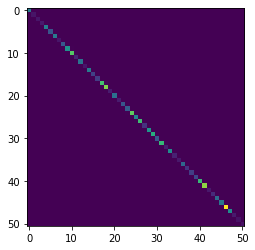

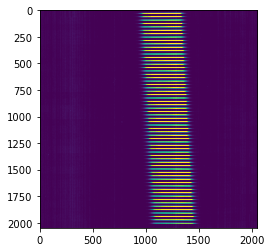

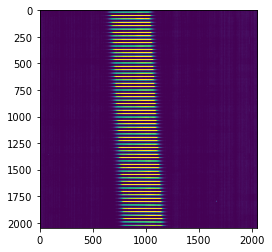

In [43]:
#NMF
import sklearn
from sklearn.decomposition import NMF

X = scans.T
X2 = n.clip(X, 0., None)

#number of independent components (does not need to be the same as the number of images used for NMF processing)
#in our case, number of components corresponds to the number of independent lenslet columns
n_comp = 51

nmf = NMF(n_components=n_comp,
         )

W=nmf.fit_transform(X2)
H=nmf.components_

fits.writeto(root+'-NMF-W-test.fits', n.reshape(W.T,(n_comp, ny, nx)), overwrite=True)
fits.writeto(root+'-NMF-H-test.fits', H, overwrite=True)

# find the index of the dominant image in each column
imax = n.argmax(H, axis=1)
uimax = n.unique(imax)
if len(uimax) != n_comp:
    ws, ws2 = [], []
    for i in uimax:
        w = n.nonzero(imax==i)[0].tolist()
        jmax = n.nonzero(H[w]==H[w].max())[0][0]
        print(w, jmax)
        ws.append(w.pop(jmax))
        ws2.extend(w)
    ws = ws+ws2
else:
    ws = n.argsort(imax)

# sort the array
Hs = H[ws,:]

#sort through the Hs values to find a maximum
Hs_max=[]
for i in range(len(Hs)):
    Hs_max.append(Hs[i].max())
Hs_max=n.array(Hs_max)

#show
fig = pylab.figure()
fig.clear()
ax = fig.add_subplot(111)
ax.imshow(Hs/Hs.max(),
          interpolation='nearest',
          #cmap=mpl.cm.RdBu,
          #vmin=-1., vmax=1.,
         )
pylab.draw()
pylab.show()

components = W.T

#sort
components = components[ws,:]

#re-shape to 2d images
components.shape = W.shape[1], ny, nx

#output as individual FITS files
for i, comp in enumerate(components):
    #account for the normalization by scaling by Hs_max
    comp=Hs_max[i]*comp
    fn = root+'-NMF-{:02d}_tutorial.fits'.format(i)
    fits.writeto(fn, comp, overwrite=True)

#example image of NMF processed white-light scan image
#each trace corresponds to a single lenslet in a given column 
image=fits.getdata("Kn3-NMF-30_tutorial.fits")
fig = pylab.figure()
fig.clear()
ax = fig.add_subplot(111)
ax.imshow(image, vmin=0, vmax=100)
pylab.draw()
pylab.show()

The output files are now processed using NMF. They can be combined to create a new rectification matrix using the OSIRIS DRP if desired.

Note: the current fits files do not have the proper header needed for the OSIRIS DRP. An example header can be found in the cell below.

More about the OSIRIS DRP and rectification matrices can be found here: https://koa.ipac.caltech.edu/UserGuide/OSIRIS/reduced_data_os.html#recmat

In [15]:
combined_data=fits.open("example_fits_header_file.fits")
NMF_header=combined_data[0].header
print(repr(NMF_header))

SIMPLE  =                    T / C# FITS: 9/4/2020 7:16:54 AM                   
BITPIX  =                  -32                                                  
NAXIS   =                    2 / Dimensionality                                 
NAXIS1  =                 2048                                                  
NAXIS2  =                 2048                                                  
EXTEND  =                    T / Extensions are permitted                       
LONGSTRN= 'OGIP 1.0'           / The OGIP Long String Convention may be used.   
EXTVER  =                    1 / Number assigned to this FITS extension         
EXTNAME = 'SCI     '           / Extension Name                                 
BUNIT   = 'ADU per second per coadd' / Physical units of the array values       
BSCALE  =                    1 / Linear factor in scaling equation              
BZERO   =                    0 / Zero point in scaling equation                 
ITIME0  =              40000